# Wstęp

Poniższy raport dotyczy analizy danych dostępnych w bazie sklepu "Geeks & Dragons", który posiada w swojej ofercie gry planszowe, prowadzi wypożyczalnię oraz organizuje turnieje.

Baza danych została wygenerowana automatycznie przy założeniu wielu uproszczeń, co ma znaczący wpływ na wyniki zawarte w analizie. Wszystkie wnioski wyciągane na podstawie analizy dotyczą wyłącznie bazy danych umieszczonej w plikach/repozytorium i nie muszą być prawdziwe w przypadku ponownego wygenerowania bazy.

# Wypełnienie bazy

Wypełnianie automatyczne bazy danych opierało się na wielu założeniach i funkcjach. Poniżej opisano najciekawsze z elementów generowania danych.

### Generowanie danych o wypożyczeniach

Dane o wypożyczeniach zostały wygenerowane symulacyjne. W trakcie symulacji klienci wypożyczali gry zmieniając ich obecny stan dla innych klientów. Dodatkowo gry mogły się zniszczyć po wypożyczeniu, po czym nie były zdatne do dalszej eksploatacji i w najbliższym czasie dodawane zostały nowe gry. Klienci wracali do sklepu w losowym czasie, a z pewnym prawdopodobieństwem nie wracali do sklepu. 

### Zczytanie danych o grach

Dane o grach zostały pobrane z BGG XML API2 na podstawie wcześniej przygotowanej listy gier. Board Game Geek (BGG) to bardzo popularne forum o grach planszowych, zawierające dużo statystyk i recenzji. Udostępnia ono darmowe API, dzięki któremu można automatycznie pobierać informację o grach. Tak pobrane dane, zostały następnie przekształcone i wrzucone do bazy danych w postaci tabeli *games*.

### Generowanie danych osobowych

Dane osobowe zostały wygenerowane na podstawie najbardziej popularnych imion i nazwisk z Stanów Zjednoczonych. Statystyki te zostały pobrane ze strony: https://github.com/fivethirtyeight/data/tree/master/most-common-name. Dodatkowo zostały wygenerowane unikalne numery telefonu i adresy email dla każdego użytkownika. Adres email mógł przybrać 10 postaci związanych z imieniem i nazwiskiem. Warianty email były złożeniem losowej kolejności imienia, nazwiska i losowych cyfr, wraz z kropkami pomiędzy członami. Dodatkowo wykorzystano kilka dostawców adresów mailowych.

# Analiza danych

Analiza danych opiera się na pytaniach jakie z dużym prawdopodobieństwem mogłbyby się pojawić podczas prowadzenia rzeczwyistej działalności "Geeks & Dragons". Pytania mają za zadanie zarówno być sprawdzeniem, jakich rezultatów możemy się spodziewać stosując zapytania na podobnej rzeczywistej bazie danych, jak również pokazać nierzeczywiste elementy w generowanej bazie danych.

#### Importy

In [1]:
from src import orm
import pandas as pd
import numpy as np
from peewee import fn
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

### Pracownik miesiąca

Pierwszym z pytań jest wybór pracownika miesiąca dla każdego z miesiąców, w którym działał sklep. Wybór ten jest określony na podstawie ilości wypożyczeń oraz sprzedaży wykonanych przez pracownika w danym miesiącu. Osoba z najwyższą liczbą sprzedaży i wypożyczeń jest ustalana jako pracownik miesiąca. Ponieważ sklep nie działał w czasie obostrzeń związanych z COVID-19 nie wszystkie miesiące są ujęte w wynikach.

In [2]:
current_date = datetime.date.today()

earliest_hired_date = orm.Employees.select(fn.Min(orm.Employees.hired_date)).scalar()

start_date = datetime.date(earliest_hired_date.year, earliest_hired_date.month, 1)
end_date = datetime.date(current_date.year, current_date.month, 1) + datetime.timedelta(days=32)

data = {}
while start_date < current_date:
    current_month = start_date.month
    current_year = start_date.year
    start_date = datetime.date(current_year, current_month, 1)
    end_date = datetime.date(current_year, current_month, 1) + datetime.timedelta(days=32)
    end_date = datetime.date(end_date.year, end_date.month, 1)
    
    # Query rentals for current month
    rentals = (orm.Rental
               .select(orm.Rental.employee_id, fn.Count(orm.Rental.employee_id).alias('rental_total'))
               .where(
                    orm.Rental.rental_date >= start_date,
                    orm.Rental.rental_date < end_date).
                group_by(orm.Rental.employee_id)
                )
    # # Query sales for current month
    sales = (orm.Sales
               .select(orm.Sales.employee_id, fn.Count(orm.Sales.employee_id).alias('sales_total'))
               .where(
                    orm.Sales.date >= start_date,
                    orm.Sales.date < end_date).
                group_by(orm.Sales.employee_id)
                )

    # Save results to list in dict format employee_id: (rental_total, sales_total)
    rentals_sales = {}
    for rental in rentals:
        rentals_sales[rental.employee_id.id] = (rental.rental_total, 0)
    for sale in sales:
        if sale.employee_id.id in rentals_sales:
            rentals_sales[sale.employee_id.id] = (rentals_sales[sale.employee_id.id][0], sale.sales_total)
        else:
            rentals_sales[sale.employee_id.id] = (0, sale.sales_total)
    # Check if dict is empty
    if rentals_sales:
        data[f"{current_year}-{current_month}"] = rentals_sales
    start_date = end_date


In [3]:
for month in data:
    employee_of_the_month = max(data[month], key=lambda x: data[month][x][0] + data[month][x][1])
    employee_of_the_month = orm.Employees.get(orm.Employees.id == employee_of_the_month)
    print(f"{month}: {employee_of_the_month.first_name} {employee_of_the_month.last_name}")


2018-6: Adrian Radziewicz
2018-7: Adrian Radziewicz
2018-8: Damian Bojarun
2018-9: Jakub Borcoń
2018-10: Marzena Rybak
2018-11: Adrian Radziewicz
2018-12: Kenneth Parker
2019-1: Heather Smith
2019-2: Kenneth Parker
2019-3: Kenneth Parker
2019-4: Marzena Rybak
2019-5: Daniel Lee
2019-6: Jakub Borcoń
2019-7: Marzena Rybak
2019-8: Kenneth Parker
2019-9: Adrian Radziewicz
2019-10: Kenneth Parker
2019-11: Adrian Radziewicz
2019-12: Adrian Radziewicz
2020-1: Marzena Rybak
2020-2: Daniel White
2020-3: Kenneth Parker
2020-5: Daniel White
2020-6: Amanda Perez
2020-7: Daniel Lee
2020-8: Amanda Perez
2020-9: Adrian Radziewicz
2020-10: Marzena Rybak
2020-11: Damian Bojarun
2020-12: Daniel White
2021-1: Damian Bojarun
2021-2: Kenneth Parker
2021-3: Adrian Radziewicz
2021-4: Marzena Rybak
2021-5: Kenneth Parker
2021-6: Daniel White
2021-7: Jakub Borcoń
2021-8: Damian Bojarun
2021-9: Kenneth Parker
2021-10: Amanda Perez
2021-11: Daniel White
2021-12: Amanda Perez
2022-1: Kenneth Parker
2022-2: Jakub 

In [4]:
employees = orm.Employees.select()
counts = {
    f"{employee.first_name} {employee.last_name}": 0 for employee in employees
}

for month in data:
    employee_of_the_month = max(data[month], key=lambda x: data[month][x][0] + data[month][x][1])
    employee_of_the_month = orm.Employees.get(orm.Employees.id == employee_of_the_month)
    counts[f"{employee_of_the_month.first_name} {employee_of_the_month.last_name}"] += 1

for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True):
    print(f"{k}: {v}")

Kenneth Parker: 13
Adrian Radziewicz: 9
Daniel Lee: 7
Marzena Rybak: 6
Damian Bojarun: 6
Jakub Borcoń: 6
Daniel White: 6
Amanda Perez: 6
Heather Smith: 1


Zgodnie z otrzymanymi wynikami jest duża rozbieżność między pracownikami. Są pracownicy, którzy znacznie częściej otrzymali tytuł pracownika miesiąca, co zgadza się z intuicją w rzeczywistej sytuacji.

### Top10 zawodników turniejowych

Dla każdej z siedmiu gier turniejowych został stworzony ranking najlepszych zawodników. Ranking ten bazuje na średnim wyniku z każdych zawodów w danej grze, w któych uczestnik brał udział.

In [5]:
# Get all unique tournament games
games = orm.Competitions.select(orm.Competitions.game_id).distinct()

top_players = {}

for game in games:
    query = (
        orm.Participants
            .select(orm.Participants.registration_id, 
                    fn.Count(orm.Participants.registration_id).alias('total'), fn.Sum(orm.Participants.score).alias('score'),
                    fn.Avg(orm.Participants.score).alias('avg_score').alias('avg_score')
                    )
            .join(orm.Competitions)
            .where(orm.Competitions.game_id == game.game_id)
            .group_by(orm.Participants.registration_id)
            .order_by(fn.Avg(orm.Participants.score).desc())
            .limit(10)
    )
    top_players[game.game_id.name] = query.execute()

In [6]:
for k, v in top_players.items():
    print(k)
    for row in v:
        print(f"{row.registration_id.first_name} {row.registration_id.last_name}: {row.avg_score}")

Reef
Daniel Smith: 199.0000000000000000
Jennifer Ramirez: 198.0000000000000000
John Sanchez: 198.0000000000000000
John Parker: 196.0000000000000000
Richard Long: 194.0000000000000000
James Long: 192.0000000000000000
David Allen: 192.0000000000000000
George Carter: 188.0000000000000000
Rachel Bailey: 187.0000000000000000
Gary Mitchell: 184.5000000000000000
UNO
Matthew Alvarez: 199.0000000000000000
Donald Price: 195.0000000000000000
Sandra Rodriguez: 195.0000000000000000
Mary Garcia: 194.0000000000000000
Julie Perez: 194.0000000000000000
Ryan Stewart: 193.0000000000000000
Jonathan Davis: 192.0000000000000000
William Mitchell: 191.0000000000000000
Zachary Nguyen: 190.0000000000000000
Justin Campbell: 188.0000000000000000
Spot it!
Christopher Parker: 199.0000000000000000
Anthony Sanchez: 199.0000000000000000
James Roberts: 197.0000000000000000
Robert Ramirez: 197.0000000000000000
Cynthia Brooks: 194.0000000000000000
James Gonzalez: 192.0000000000000000
James Jackson: 190.0000000000000000
E

Zgodnie z intuicją związaną z systemem tworzenia rankingu znaczącą przewagę mają osoby, które w zawodach brały udział jeden raz. Wyniki zawodników są losowe, więc znacznie łatwiej jest uzyskać wysoką średnią z niewielu prób, niż gdy próba jest znacząco większa.

### Najbardziej dochodowe gry

Najbardziej dochodowe gry zostały wyznaczone na podstawie obrotu związanego z daną grą podczas sprzedaży oraz wypożyczeń.

In [7]:
sales = (
    orm.Sales
        .select(
            orm.GamesToSell.game_id, 
            fn.Sum(orm.GamesToSell.price))
        .join(orm.GamesToSell)
        .group_by(orm.GamesToSell.game_id)
        .order_by(fn.Sum(orm.GamesToSell.price).desc())
)

rentals = (
    orm.Rental
        .select(
            orm.GamesToRent.game_id, 
            fn.Sum(orm.GamesToRent.price * (1.0 - orm.GamesToRent.discount)))
        .join(orm.GamesToRent)
        .group_by(orm.GamesToRent.game_id)
        .order_by(fn.Sum(orm.GamesToRent.price * (1.0 - orm.GamesToRent.discount)).desc())
)

In [8]:
games_total = {}

for sale in sales:
    games_total[sale.game_id.game_id.name] = sale.sum
    
for rental in rentals:
    if rental.game_id.game_id.name in games_total:
        games_total[rental.game_id.game_id.name] += rental.sum
    else:
        games_total[rental.game_id.game_id.name] = rental.sum

c = 10
for k, v in sorted(games_total.items(), key=lambda item: item[1], reverse=True):
    print(f"{k}: {v:.2f}")
    c -= 1
    if c == 0:
        break

IKI: 26708.00
The Shipwreck Arcana: 22296.72
Tainted Grail: The Fall of Avalon: 22010.19
Exit: The Game – Dead Man on the Orient Express: 21981.13
The Resistance: Avalon: 21838.13
Blood on the Clocktower: 21833.81
The LOOP: 21262.85
Evolution: Climate: 20748.94
Schotten Totten: 20396.94
Mascarade: 19734.75


Gry, które okazały się najbardziej dochodowe są również najdroższymi grami. Ceny gier oraz popularność nie była wyznaczona na podstawie rzeczywistych danych, więc wyniki te nie należy traktować jako rzeczywista przewaga jednej gry nad drugą. W rzeczywistości analizie powinny podlegać zyski, a nie obrót w celu uzyskania bardziej miarodajnych wyników.

### Czy turnieje wpływają na wypożyczenia i zakupy danej gry?

Dla ostatnich 5 turniejów zostało sprawdzone, czy liczba wypożyczeń oraz sprzedaży jest większa w bliskim (tygodniowym) odstępie czasu od turnieju danej gry w porównaniu z ogólną liczbą wypożyczeń i sprzedaży tej gry.

In [26]:
# Get days from first sale to last sale
first_sale = orm.Sales.select().order_by(orm.Sales.date.asc()).limit(1).get()
last_sale = orm.Sales.select().order_by(orm.Sales.date.desc()).limit(1).get()
days = (last_sale.date - first_sale.date).days

# Get last 5 tournaments
tournaments = orm.Competitions.select().order_by(orm.Competitions.date.desc()).limit(5)

for tournament in tournaments:
    tournament_date = tournament.date
    tournament_game = tournament.game_id

    tour_rentals = orm.Rental.select().where(
        orm.Rental.rental_date <= tournament_date + datetime.timedelta(days=14),
        orm.Rental.rental_date >= tournament_date - datetime.timedelta(days=14),
        orm.Rental.game_id == tournament_game
    )

    tour_sales = orm.Sales.select().where(
        orm.Sales.date <= tournament_date + datetime.timedelta(days=14),
        orm.Sales.date >= tournament_date - datetime.timedelta(days=14),
        orm.Sales.game_id == tournament_game
    )


    # Get total number of rentals and sales for this game
    all_rentals = orm.Rental.select().where(
        orm.Rental.game_id == tournament_game
    )

    all_sales = orm.Sales.select().where(
        orm.Sales.game_id == tournament_game
    )

    # datetime to strftime
    print(f"{tournament_game.name} {tournament_date.strftime('%Y-%m-%d')}\n\tTOUR_RENTALS={len(tour_rentals) / 28} TOUR_SALES={len(tour_sales) / 28} ALL_RENTALS={len(all_rentals) / days} ALL_SALES={len(all_sales) / days}")


SET 2023-07-29
	TOUR_RENTALS=0.0 TOUR_SALES=0.0 ALL_RENTALS=0.0021598272138228943 ALL_SALES=0.06911447084233262
Reef 2023-07-19
	TOUR_RENTALS=0.0 TOUR_SALES=0.0 ALL_RENTALS=0.0010799136069114472 ALL_SALES=0.07073434125269978
Magic Maze 2023-07-07
	TOUR_RENTALS=0.0 TOUR_SALES=0.0 ALL_RENTALS=0.0021598272138228943 ALL_SALES=0.06533477321814254
Carcassonne 2023-06-17
	TOUR_RENTALS=0.0 TOUR_SALES=0.03571428571428571 ALL_RENTALS=0.0005399568034557236 ALL_SALES=0.06317494600431965
Azul 2023-06-03
	TOUR_RENTALS=0.0 TOUR_SALES=0.10714285714285714 ALL_RENTALS=0.0016198704103671706 ALL_SALES=0.07451403887688984


Otrzymane wyniki sugerują, że turnieje nie wpływają na popularność danej gry. W rzeczywistej sytuacji bardziej prawdopdobną sytuacją jest wzrost sprzedaży oraz wypożyczeń. 

Wartym zauważenia jest fakt małej liczby wypożyczeń danej gry w ciągu dwóch tygodni, w któych odbywa się turniej. Jest to spowodowane faktem dużej ilości gier dostępnych w sklepie, a przez to małą szansą na wpożyczenie konkretnego tytułu.

### Ocena zadowolenia klientów

Ocena zadowolenia klientów została przeprowadzona na podstawie ponownych wypożyczeń wykonanych przez tą samą osobę.

<Axes: >

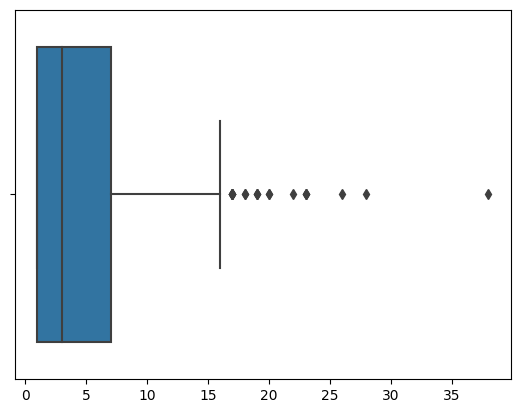

In [10]:
# Get average number of rentals per client
rentals = orm.Rental.select(orm.Rental.customer_id, fn.Count(orm.Rental.customer_id).alias('count')).group_by(orm.Rental.customer_id)

# Seaborn boxplot
sns.boxplot(x=[rental.count for rental in rentals])

Na podstawie wykresu pudełkowego widzimy, że większość klientów po kilku wypożyczeniach gier już nie wraca do sklepu. Zgadza się to z generacją danych, w której założono, że z prawdopodobieństwem 0.2 klient po wypożyczeniu gry więcej nie wróci do sklepu.

Zadowolenie klientów możemy ocenić jako średnie, ponieważ liczba wypożyczeń jest dość niska. Pojawiają się obserwacje odstające - stali klienci, którzy wypożyczają znacznie więcej gier od pozostałych.

### Najbardziej popularne kategorie i mechaniki gier

Jako jedną z informacji o grach znamy ich kategorie oraz mechaniki. Najbardziej popularne zostały określone jako najczęściej występujące.

In [11]:
# Get count of sales per game
sales = orm.Sales.select(orm.Sales.game_id, fn.Count(orm.Sales.game_id).alias('count')).group_by(orm.Sales.game_id)
# Get count of rentals per game
rentals = orm.Rental.select(orm.Rental.game_id, fn.Count(orm.Rental.game_id).alias('count')).group_by(orm.Rental.game_id)

categories_popularity = {}
mechanics_popularity = {}

for sale in sales:
    categories = sale.game_id.game_id.category
    mechanics = sale.game_id.game_id.mechanic

    for category in categories.split(','):
        if category in categories_popularity:
            categories_popularity[category] += sale.count
        else:
            categories_popularity[category] = sale.count

    for mechanic in mechanics.split(','):
        if mechanic in mechanics_popularity:
            mechanics_popularity[mechanic] += sale.count
        else:
            mechanics_popularity[mechanic] = sale.count

for rental in rentals:
    categories = rental.game_id.game_id.category
    mechanics = rental.game_id.game_id.mechanic

    for category in categories.split(','):
        if category in categories_popularity:
            categories_popularity[category] += rental.count
        else:
            categories_popularity[category] = rental.count

    for mechanic in mechanics.split(','):
        if mechanic in mechanics_popularity:
            mechanics_popularity[mechanic] += rental.count
        else:
            mechanics_popularity[mechanic] = rental.count

# Print Top 10 categories
print("===KATEGORIE===")
c = 10
for k, v in sorted(categories_popularity.items(), key=lambda item: item[1], reverse=True):
    print(f"{k}: {v}")
    c -= 1
    if c == 0:
        break

print("===MECHANIKI===")
# Print Top 10 mechanics
c = 10
for k, v in sorted(mechanics_popularity.items(), key=lambda item: item[1], reverse=True):
    print(f"{k}: {v}")
    c -= 1
    if c == 0:
        break

===KATEGORIE===
Card Game: 11817
Fantasy: 6704
Economic: 6268
Animals: 3968
Exploration: 3702
Fighting: 3663
Science Fiction: 3510
Party Game: 3208
Deduction: 2978
Adventure: 2930
===MECHANIKI===
Hand Management: 14142
Variable Player Powers: 10746
Solo / Solitaire Game: 10255
Set Collection: 9863
Open Drafting: 7897
Dice Rolling: 6931
Cooperative Game: 6007
Tile Placement: 5483
End Game Bonuses: 5134
Variable Set-up: 4713


Zgodnie z otrzymanymi wynikami widzimy, że niektóre kategorie i mechaniki są znacznie popularniejsze od pozostałych. W przypadku naszej symulacji jest to spowodowane ilością gier, która jest określana jako z danej kategorii lub zawierająca daną mechanikę (gra może należeć do więcej niż jednej kategorii i być dopasowana do więcej niż jednej mechaniki).

### Koszt gier a wypożyczenia i zakupy

Naturalnym jest, że spodziewamy się, że tańsze gry będą częściej sprzedawane niż wypożyczane, a droższe na odwrót. Poniżej sprawdzamy, czy ta zależność również jest do zaobserwowania w wygenerowanej bazie.

In [12]:
# Get min and max game cost
min_cost = orm.GamesToSell.select(fn.Min(orm.GamesToSell.price)).scalar()
max_cost = orm.GamesToSell.select(fn.Max(orm.GamesToSell.price)).scalar()
min_cost, max_cost

(60.0, 200.0)

In [13]:
splits = np.linspace(min_cost, max_cost, 10)

for min_cost, max_cost in zip(splits, splits[1:]):
    count = orm.GamesToSell.select().where(
        orm.GamesToSell.price >= min_cost,
        orm.GamesToSell.price < max_cost
    ).count()

    print(f"{min_cost:.2f}-{max_cost:.2f}: {count}")

60.00-75.56: 43
75.56-91.11: 39
91.11-106.67: 47
106.67-122.22: 45
122.22-137.78: 30
137.78-153.33: 20
153.33-168.89: 8
168.89-184.44: 1
184.44-200.00: 0


In [14]:
# Get min and max game cost
min_cost = orm.GamesToRent.select(fn.Min(orm.GamesToRent.price * (1.0 - orm.GamesToRent.discount))).scalar()
max_cost = orm.GamesToRent.select(fn.Max(orm.GamesToRent.price * (1.0 - orm.GamesToRent.discount))).scalar()
min_cost, max_cost

(4.199999999999999, 20.0)

In [15]:
splits = np.linspace(min_cost, max_cost, 10)

for min_cost, max_cost in zip(splits, splits[1:]):
    count = orm.GamesToRent.select().where(
        orm.GamesToRent.price * (1.0 - orm.GamesToRent.discount) >= min_cost,
        orm.GamesToRent.price * (1.0 - orm.GamesToRent.discount) < max_cost
    ).count()

    print(f"{min_cost:.2f}-{max_cost:.2f}: {count}")

4.20-5.96: 41
5.96-7.71: 253
7.71-9.47: 249
9.47-11.22: 238
11.22-12.98: 210
12.98-14.73: 120
14.73-16.49: 60
16.49-18.24: 7
18.24-20.00: 0


Z otrzymanych wyników nie jesteśmy w stanie zauważyć bezpośredniej zależności między ceną gry, a liczbą jej sprzedaży i wypożyczeń.

### Ile klienci płacą dodatkowych opłat?

Pytanie dotyczące płacenia dodatkowych opłat może być pomocne przy określaniu wielkości tych opłat w przyszłości i ustalaniu okresu bazowego, dla którego nie podnosimy opłaty.

In [16]:
# Count each additional_payment_id in rental
res = (
    orm.Rental
        .select(orm.Rental.additional_payment_id.alias('ap_id'), fn.Count(orm.Rental.additional_payment_id).alias('count'))
        .where(orm.Rental.additional_payment_id.is_null(False))
        .group_by(orm.Rental.additional_payment_id)
).execute()

# Sort by percent\
res = sorted(res, key=lambda x: orm.AdditionalPayment.get(orm.AdditionalPayment.id == x.ap_id).payment_percent, reverse=False)
for r in res:
    # print(r.ap_id, type(r.ap_id))
    ap = orm.AdditionalPayment.get(orm.AdditionalPayment.id == r.ap_id)
    print(f"{ap.payment_percent}: {r.count}")

0.0: 2433
0.1: 55
0.2: 49
0.5: 33


Większosć klientów zwraca grę wciągu tygodnia, dla którego nie przyznajemy dodatkowej opłaty. Dla nielicznych przypadków została naliczona opłata dodatkowa, co sugeruje, że wyznaczony bazowy termin oddania gry - tydzień jest odpowiednio dobrany.

### W jakich godzinach jest najwięcej zakupów i wypożyczeń?

Na podstawie ilości sprzedaży oraz wypożyczeń w ciągu dnia możemy określać liczbę pracowników pracująch w danych godzinach.

In [23]:
res = (
    orm.Rental
        .select(
            orm.db.extract_date('hour', orm.Rental.rental_date).alias("hour"),
            fn.Count(orm.Rental.id).alias("count")
        )
        .group_by(orm.db.extract_date('hour', orm.Rental.rental_date))
        .order_by(orm.db.extract_date('hour', orm.Rental.rental_date))
)

for r in res:
    print(f"{r.hour}: {r.count}")

10: 330
11: 393
12: 339
13: 397
14: 355
15: 392
16: 387


In [25]:
res = (
    orm.Sales
        .select(
            orm.db.extract_date('hour', orm.Sales.date).alias("hour"),
            fn.Count(orm.Sales.id).alias("count")
        )
        .group_by(orm.db.extract_date('hour', orm.Sales.date))
        .order_by(orm.db.extract_date('hour', orm.Sales.date))
)

for r in res:
    print(f"{r.hour}: {r.count}")

10: 3734
11: 3751
12: 3699
13: 3800
14: 3832
15: 3789
16: 3899
17: 3751


Godzina nie wpływa na liczbę sprzedaży i wypożyczeń, przez co możemy wnioskować, że przez cały okres otwarcia sklepu (od 10:00 do 18:00) powinno być tyle samo pracowników. Sytuacja taka jest mało prawdopdobna w rzeczywistości.

# Podsumowanie

Stworzona baza danych pozwala na przeprowadzanie analiz danych sklepu. Jest ona wystarczająca do sprawdzenie wielu zależności i korzystanie z niej nie sprawia problemów. Częściowo oddaje ona rzeczywiste dane, ale nie jest to do końca spełnione, w związku z wciąż mała realnością sposobu generowania danych. Generowanie bardziej realnych danych jest znacznie trudniejszym zadaniem wymagającym więcej pracy, które może byc nie opłacalne w celach podstawowej analizy.

## 